# VISION AND COGNITIVE SYSTEM :

### Hand Detection and Segmentation

- Name and Surname : Asal Rangrazi Asl 
- Student ID : 2046832

### project aim:

- This project mainly focuses on object detection and segmentation

- Image classification

- Object localization

- Final tuning

- hand instance segmentation


### R-CNN :

- R-CNN (Regions with Convolutional Neural Networks) is a popular computer vision method for object detection and classification.

- R-CNN has been successful in many object detection tasks, including hand detection. 

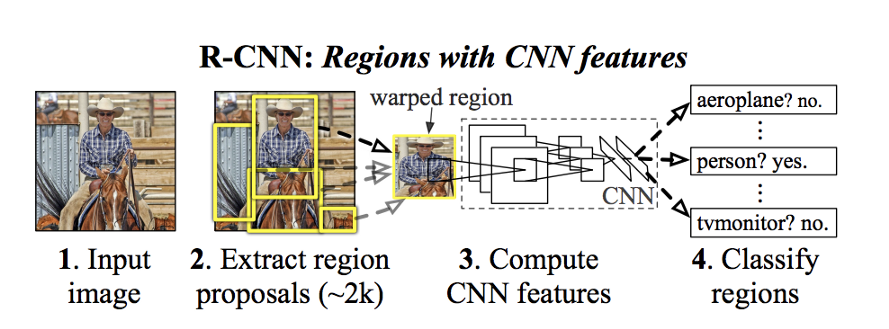

In [1]:
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os

import pickle

import numpy as np
import csv
import itertools
import imutils

from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.models import load_model
#from imutils.object_detection import non_max_suppression


### dataset:

- we define the paths to the dataset.

- we establish the paths to our positive (i.e,. there is a hand) and negative (i.e., no hand in the input image) example images.

- we define the maximum number of Selective Search region(MAX_PROPOSALS,MAX_PROPOSALS_INFER)

- maximum number of positive and negative regions(MAX_POSITIVE,MAX_NEGATIVE)

- I use classification network (VGG16). 

In [42]:
OBJECT_TO_DETECT = 'hand'

ORIG_BASE_PATH = "/Users/asalrangraziasl/Documents/ vision project/finalcv/dataset"
ORIG_IMAGES = os.path.sep.join([ORIG_BASE_PATH, "images"])
ORIG_ANNOTS = os.path.sep.join([ORIG_BASE_PATH, "annotations"])

TEST_BASE_PATH = "/Users/asalrangraziasl/Documents/ vision project/finalcv/dataset_test"
TEST_IMAGES = os.path.sep.join([TEST_BASE_PATH, "images"])
TEST_ANNOTS = os.path.sep.join([TEST_BASE_PATH, "annotations"])
TEST_ANNOTS_OUT = os.path.sep.join([TEST_BASE_PATH, "annotations_OUT"])


BASE_PATH = "/Users/asalrangraziasl/Documents/ vision project/finalcv/training_data"
POSITVE_PATH = os.path.sep.join([BASE_PATH, "hand"])
NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_hand"])

BASE_RESULT_PATH = '/Users/asalrangraziasl/Documents/ vision project/finalcv/results'
RESULT_IMAGE_PATH = os.path.sep.join([BASE_RESULT_PATH, "images"])

RESULT_MODEL_PATH_MobileNet = os.path.sep.join([BASE_RESULT_PATH, "model_mobilenet"])
RESULT_MODEL_PATH_CNN = os.path.sep.join([BASE_RESULT_PATH, "model_cnn"])
RESULT_MODEL_PATH_Inception = os.path.sep.join([BASE_RESULT_PATH, "model_inception"])
RESULT_MODEL_PATH_EfficientNetB0 = os.path.sep.join([BASE_RESULT_PATH, "model_model_EfficientNetB0"])

ENCODER_PATH = RESULT_MODEL_PATH_MobileNet + "/label_encoder_hand.pickle"

MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200

MAX_POSITIVE = 30
MAX_NEGATIVE = 10

INPUT_DIMS = (224, 224)
INPUT_DIMS_3D = (224, 224, 3)

### Measuring object detection accuracy with IoU:

- Intersection over Union (IoU) is a commonly used metric to evaluate the accuracy of object detection algorithms.

- The IoU metric ranges from 0 to 1, where a value of 1 indicates a perfect match between the predicted and ground-truth bounding boxes, and a value of 0 indicates no overlap between the boxes.

In [3]:
import cv2
import numpy as np


def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


def evaluate_iou(boxes_ground_truth, boxes_predict):
    evals = []
    for box_ in boxes_ground_truth:
        eval = [compute_iou(box_, box_p) for box_p in boxes_predict]
        print(eval)
        print(max(eval))
        evals.append(max(eval))
    return evals


def colors_(number_needed):
    all = [[0, 0, 0]]
    for i in range(1, int(number_needed/7)+2):
        x = i*30
        x = 255 - x
        all += [
            [x, 0, 0],
            [0, x, 0],
            [0, 0, x],

            [x, x, 0],
            [0, x, x],
            [x, 0, x],

            [x, x, x],
        ]
    return np.uint8(all)


def erosion_(image, image_path, kernel):
    if image is None:
        image = cv2.imread(image_path)

    element = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * kernel + 1, 2 * kernel + 1),
        (kernel, kernel)
    )
    image_dilatation = cv2.erode(image, element)
    # image_merged = cv2.vconcat([image, image_dilatation])
    # cv2.imshow('dilation_dilation_', image_merged)
    # cv2.waitKey()
    return image_dilatation


def parse_annotations(str_annot):
    bbox_all = []
    for line in str_annot.split("\n"):
        bbox = []
        for x in line.split("\t"):
            for i in x.split(" "):
                bbox.append(int(i))
        bbox_all.append(bbox)
    return bbox_all


###  dataset :

- Load thea given input image.

-  gtBoxes list will soon hold our dataset’s ground-truth bounding boxes.


In [4]:
for dirPath in (POSITVE_PATH,NEGATIVE_PATH):
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

imagePaths = list(paths.list_images(ORIG_IMAGES))
print(len(imagePaths))

41


### important note :

- Our positive and negative directories will soon contain our hand or no hand images.

In [5]:
totalPositive = 0
totalNegative = 0

for (i, imagePath) in enumerate(imagePaths):
    print("[INFO] processing image {}/{}...".format(i + 1, len(imagePaths))) # storing the hand data
    
    #this file contains the ground-truth object detection annotations for the current image
    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([ORIG_ANNOTS, "{}.xml".format(filename)])

    contents = open(annotPath).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = [] # will hold our dataset’s ground-truth bounding boxes 

    w = int(soup.find("width").string)
    h = int(soup.find("height").string)

    #grab bounding box coordinates from all the <object> elements in our annotation file:
    for o in soup.find_all("object"):
        #Extract the label as well as the bounding box coordinates 
        label = o.find("name").string
        xMin = float(o.find("xmin").string)
        yMin = float(o.find("ymin").string)
        xMax = float(o.find("xmax").string)
        yMax = float(o.find("ymax").string)

        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)
        gtBoxes.append((xMin, yMin, xMax, yMax))#Update our list of ground-truth bounding boxes
    
    #load an image and perform Selective Search
    image = cv2.imread(imagePath)

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects = []

    for (x, y, w, h) in rects:
        proposedRects.append((x, y, x + w, y + h))
        
    #we will use IoU to determine which regions overlap sufficiently with the ground-truth boxes and which do not
    positiveROIs = 0
    negativeROIs = 0

    for proposedRect in proposedRects[:MAX_PROPOSALS]:
        (propStartX, propStartY, propEndX, propEndY) = proposedRect

        # loop over the ground-truth bounding boxes
        for gtBox in gtBoxes:
            # compute the intersection over union between the two
            # boxes and unpack the ground-truth bounding box
            iou = compute_iou(gtBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

            # initialize the ROI and output path
            roi = None
            outputPath = None

            if iou > 0.7 and positiveROIs <= MAX_POSITIVE:
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalPositive)
                outputPath = os.path.sep.join([POSITVE_PATH, filename])

                positiveROIs += 1
                totalPositive += 1

            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY

            if not fullOverlap and iou < 0.05 and negativeROIs <= MAX_NEGATIVE:
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalNegative)
                outputPath = os.path.sep.join([NEGATIVE_PATH, filename])

                negativeROIs += 1
                totalNegative += 1

            if roi is not None and outputPath is not None:
                roi = cv2.resize(roi,INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

[INFO] processing image 1/41...
[INFO] processing image 2/41...
[INFO] processing image 3/41...
[INFO] processing image 4/41...
[INFO] processing image 5/41...
[INFO] processing image 6/41...
[INFO] processing image 7/41...
[INFO] processing image 8/41...
[INFO] processing image 9/41...
[INFO] processing image 10/41...
[INFO] processing image 11/41...
[INFO] processing image 12/41...
[INFO] processing image 13/41...
[INFO] processing image 14/41...
[INFO] processing image 15/41...
[INFO] processing image 16/41...
[INFO] processing image 17/41...
[INFO] processing image 18/41...
[INFO] processing image 19/41...
[INFO] processing image 20/41...
[INFO] processing image 21/41...
[INFO] processing image 22/41...
[INFO] processing image 23/41...
[INFO] processing image 24/41...
[INFO] processing image 25/41...
[INFO] processing image 26/41...
[INFO] processing image 27/41...
[INFO] processing image 28/41...
[INFO] processing image 29/41...
[INFO] processing image 30/41...
[INFO] processing i

### fine_tune rcnn : 

- Fine-tuning a network for object detection with Keras and TensorFlow

- now ready to fine-tune a classification CNN to recognize both of these classes

In [6]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2, VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.cluster import estimate_bandwidth, MeanShift
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import pickle
import os

import cv2


In [7]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))

[INFO] loading images...


In [8]:
data = []
labels = []


for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]

    image = load_img(imagePath, target_size=INPUT_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

print('imagePaths: ', len(imagePaths))
print('data: ', len(data))
print('labels: ', len(labels))

imagePaths:  631
data:  631
labels:  631


In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(
    data,
    labels,
    test_size=0.3,
    stratify=labels,
)
print('trainX: ', trainX.shape, 'testX: ', testX.shape, 'trainY: ', trainY.shape, 'testY: ', testY.shape)

trainX:  (441, 224, 224, 3) testX:  (190, 224, 224, 3) trainY:  (441, 2) testY:  (190, 2)


In [10]:
# construct the training image generator for data augmentation

aug = ImageDataGenerator(
    # rescale=1/255.,
    rotation_range=90,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [11]:
def raw_model_VGG16():

    baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

    for layer in baseModel.layers:
        layer.trainable = False

    headModel = Flatten()(baseModel.output)
    headModel = Dense(128, activation='relu')(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(2, activation='sigmoid')(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    model.compile(loss="categorical_crossentropy", optimizer=RMSprop(lr=0.0006),
                  metrics=["accuracy"])
    return model


def fit_model(model, path_to_save):
    print("[INFO] training head...")
    batch_size = 128

    H = model.fit(
        aug.flow(trainX, trainY, batch_size=batch_size, shuffle=True),
        steps_per_epoch=len(trainX) // batch_size,
        validation_data=(testX, testY),
        validation_steps=len(testX) // batch_size,
        epochs=15,
        shuffle=True
    )
    # make predictions on the testing set
    print("[INFO] evaluating network...")
    predIdxs = model.predict(testX, batch_size=128)
    predIdxs = np.argmax(predIdxs, axis=1)
    print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

    print("[INFO] saving mask detector model...")
    model.save(
        path_to_save,
        # save_format="h5"
    )
    print("[INFO] saving label encoder...")
    f = open(path_to_save+'/label_encoder_hand.pickle', "wb")
    f.write(pickle.dumps(lb))
    f.close()
    return H


model = raw_model_VGG16()
H=fit_model(model, RESULT_MODEL_PATH_MobileNet)


/Users/asalrangraziasl/Library/Python/3.8/lib/python/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] training head...
Epoch 1/15


2023-02-09 16:47:48.040838: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 58s 22s/step - loss: 2.0194 - accuracy: 0.6677 - val_loss: 3.4854 - val_accuracy: 0.7158
Epoch 2/15
3/3 [==============================] - 57s 22s/step - loss: 1.4794 - accuracy: 0.7859 - val_loss: 0.4176 - val_accuracy: 0.8579
Epoch 3/15
3/3 [==============================] - 55s 24s/step - loss: 0.3108 - accuracy: 0.8786 - val_loss: 0.4407 - val_accuracy: 0.7947
Epoch 4/15
3/3 [==============================] - 67s 26s/step - loss: 0.2818 - accuracy: 0.8906 - val_loss: 0.2884 - val_accuracy: 0.8632
Epoch 5/15
3/3 [==============================] - 58s 22s/step - loss: 0.2434 - accuracy: 0.8914 - val_loss: 0.2908 - val_accuracy: 0.8895
Epoch 6/15
3/3 [==============================] - 57s 22s/step - loss: 0.2834 - accuracy: 0.8914 - val_loss: 0.4755 - val_accuracy: 0.7789
Epoch 7/15
3/3 [==============================] - 56s 21s/step - loss: 0.3484 - accuracy: 0.8594 - val_loss: 0.2470 - val_accuracy: 0.8842
Epoch 8/15
3/3 [======================

INFO:tensorflow:Assets written to: results/model_mobilenet/assets


INFO:tensorflow:Assets written to: results/model_mobilenet/assets


[INFO] saving label encoder...


In [12]:
#model.save('TRAINING_MODEL', save_format="h5")

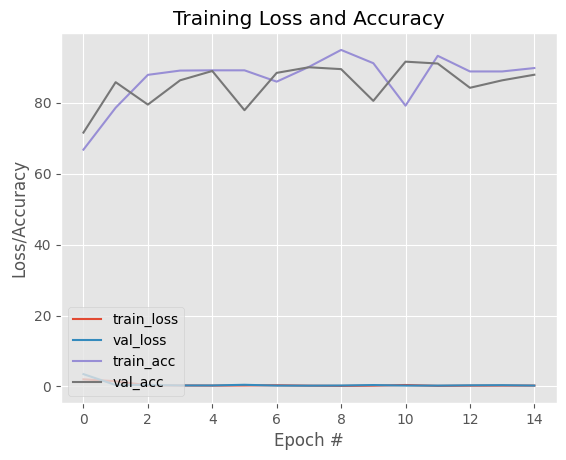

In [13]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt

N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), np.array(H.history["accuracy"])*100, label="train_acc")
plt.plot(np.arange(0, N), np.array(H.history["val_accuracy"])*100, label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


load the saved model :

In [14]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model('TRAINING_MODEL')
lb = pickle.loads(open(ENCODER_PATH, "rb").read())


[INFO] loading model and label binarizer...


In [15]:
# load the input image from disk
image = cv2.imread("/Users/asalrangraziasl/Documents/ vision project/finalcv/dataset/images/010000_hand.jpg")
image = imutils.resize(image, width=500)

### detect object R_CNN:  

- (1) load our model,

- (2) load our image,

- (3) perform Selective Search:

In [16]:
def roi_seg(image, boxes):
    boxes_ = []
    proposals = []
    for (startX, startY, endX, endY) in boxes:
        if endY-startY < 15 or endX-startX < 15:
            continue
        roi = image[startY:endY, startX:endX]
        roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)

        # cv2.imshow(str(len(proposals))+'___'+str(startX)+str(endY), roi)

        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        boxes_.append([startX, startY, endX, endY])
        proposals.append(roi)

    proposals = np.array(proposals, dtype="float32")
    boxes_ = np.array(boxes_, dtype="int32")
    print('boxes: ', boxes_.shape)
    print('proposals: ', proposals.shape)
    return proposals, boxes_


def detect(config, RESULT_MODEL_PATH, image, image_path, boxes, proposals):
    print("[INFO] loading model and label binarizer from {}".format(RESULT_MODEL_PATH))
    model = load_model(RESULT_MODEL_PATH)
    lb = pickle.loads(open(config.ENCODER_PATH, "rb").read())

    # image = imutils.resize(image, width=500)

    print("[INFO] classifying proposals...")
    proba = model.predict(proposals)
    print("[INFO] applying NMS...")
    labels = lb.classes_[np.argmax(proba, axis=1)]
    # idxs = np.where(labels == config.OBJECT_TO_DETECT)[0]

    boxes_ = []
    proba_ = []
    for i in range(len(proba)):
        if proba[i][0] > proba[i][1]:
            boxes_.append(boxes[i])
            proba_.append(proba[i][0])
    proba_ = np.array(proba_)
    boxes_ = np.array(boxes_)

    clone = image.copy()
    for (box, prob) in zip(boxes_, proba_):
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        text = "{}: {:.2f}%".format(config.OBJECT_TO_DETECT, prob * 100)
        cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    boxIdxs = non_max_suppression(boxes_, proba_)
    #clone the original image so that we can draw on it
    clone_nms = image.copy()
    for i in boxIdxs:
        # (startX, startY, endX, endY) = boxes[i]
        (startX, startY, endX, endY) = i
        cv2.rectangle(clone_nms, (startX, startY), (endX, endY), (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        # text = "{}: {:.2f}%".format(config.OBJECT_TO_DETECT, proba[i] * 100)
        text = config.OBJECT_TO_DETECT
        cv2.putText(clone_nms, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    
    image_merged = cv2.vconcat([image, clone, clone_nms])
    # cv2.imshow("image_merged", image_merged)
    # cv2.waitKey()

    file_name_ex = image_path.split('/')[-1]
    file_name = file_name_ex.split('.')[0]
    ex = '.' + file_name_ex.split('.')[1]
    full_path_img_image_merged = config.RESULT_IMAGE_PATH + '/' + file_name + ex

    cv2.imwrite(full_path_img_image_merged, image_merged)

    return boxes_


### Hand segmentation part :

- we will use  segmentation model by defining it in function.

- MeanShift: is a method for image segmentation that is based on the idea of clustering pixels in feature space. The goal of MeanShift is to separate an image into different regions that correspond to distinct objects or features in the image.The basic idea behind MeanShift is to treat each pixel in the image as a point in a high-dimensional feature space. The algorithm then iteratively shifts each.
 
 

In [17]:
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.cluster import estimate_bandwidth, MeanShift
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import pickle
import os
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth


In [18]:
def segment_meanshift(image, image_path_, kernel=1):
    if image is None:
        image = cv.imread(image_path_)

    img_blured = image
    img_blured = cv.cvtColor(img_blured, cv.COLOR_BGR2HSV)
    flat_image = np.float32(img_blured.reshape((-1, 3)))

    bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_image)
    labeled = ms.labels_

    segments = np.unique(labeled)

    result = colors_(segments.shape[0])[labeled].reshape((image.shape))

    # cv.imshow('meanshift'+str(kernel), result)
    # cv.waitKey()

    return result


In [19]:
def find_countours(image, kernel=5):
    layers = cv.split(image)
    # image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    def get_contours(image_1_layer):
        contours1, hierarchy1 = cv.findContours(
            image=image_1_layer,
            mode=cv.RETR_TREE,
            method=cv.CHAIN_APPROX_SIMPLE
        )

        image_contour = image.copy()
        cv.drawContours(
            image=image_contour,
            contours=contours1,
            contourIdx=-1,
            color=(0, 255, 0),
            thickness=2,
            lineType=cv.LINE_AA
        )
        return image_contour, contours1, hierarchy1

    def get_boxes(image_, contours):
        boxes = []
        for each_rect in contours:
            startX=10000; startY=10000; endX=0; endY=0
            for each_coord in each_rect:
                startX = min(each_coord[0][0], startX)
                startY = min(each_coord[0][1], startY)
                endX = max(each_coord[0][0], endX)
                endY = max(each_coord[0][1], endY)
            cv.rectangle(image_, (startX, startY), (endX, endY), (255, 255, 0), 2)
            boxes.append([startX, startY, endX, endY])
        return boxes

    boxes = []
    images_ = []
    for i in layers:
        im, co, hi = get_contours(i)
        boxes += get_boxes(im, co)
        images_.append(im)

    print('Image Segmented with kernel: {}'.format(kernel))
    # image_merged_layers = cv.vconcat(layers)
    # image_merged_images = cv.vconcat(images_)
    # cv.imshow('Splited'+str(kernel), image_merged_layers)
    # cv.imshow('Contour'+str(kernel), image_merged_images)
    # cv.waitKey()

    return boxes

In [34]:
from imutils.object_detection import non_max_suppression

def detect(RESULT_MODEL_PATH, image, image_path, boxes, proposals):
    print("[INFO] loading model and label binarizer from {}".format(RESULT_MODEL_PATH))
    model = load_model(RESULT_MODEL_PATH)
    lb = pickle.loads(open(ENCODER_PATH, "rb").read())

    # image = imutils.resize(image, width=500)

    print("[INFO] classifying proposals...")
    proba = model.predict(proposals)
    print("[INFO] applying NMS...")
    labels = lb.classes_[np.argmax(proba, axis=1)]
    # idxs = np.where(labels == OBJECT_TO_DETECT)[0]

    boxes_ = []
    proba_ = []
    for i in range(len(proba)):
        if proba[i][0] > proba[i][1]:
            boxes_.append(boxes[i])
            proba_.append(proba[i][0])
    proba_ = np.array(proba_)
    boxes_ = np.array(boxes_)
 

    clone = image.copy()
    for (box, prob) in zip(boxes_, proba_):
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        text = "{}: {:.2f}%".format(OBJECT_TO_DETECT, prob * 100)
        cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    boxIdxs = non_max_suppression(boxes_, proba_)
    clone_nms = image.copy()
    for i in boxIdxs:
        # (startX, startY, endX, endY) = boxes[i]
        (startX, startY, endX, endY) = i
        cv2.rectangle(clone_nms, (startX, startY), (endX, endY), (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        # text = "{}: {:.2f}%".format(OBJECT_TO_DETECT, proba[i] * 100)
        text = OBJECT_TO_DETECT
        cv2.putText(clone_nms, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    image_merged = cv2.vconcat([image, clone, clone_nms])
    # cv2.imshow("image_merged", image_merged)
    # cv2.waitKey()

    file_name_ex = image_path.split('/')[-1]
    file_name = file_name_ex.split('.')[0]
    ex = '.' + file_name_ex.split('.')[1]
    extension = 'Ext'
    full_path_img_image_merged = RESULT_IMAGE_PATH + '/' + file_name + extension + ex

    cv2.imwrite(full_path_img_image_merged, image_merged)

    return boxes_

def parse_annotations(str_annot):
    print('str_annot:',str_annot)
    bbox_all = []
    for line in str_annot.split("\n"):
        bbox = []
        for x in line.split("\t"):
            print('x:',x)
            for i in x.split(" "):
                bbox.append(int(i))
        bbox_all.append(bbox)
    return bbox_all

### run :

- In this section we will run our code by using the segmented function which we defined it:(segment_meanshift)


In [52]:
def detect_object_rcnn(model_path):
    annotation_paths = os.listdir(TEST_ANNOTS)

    for index, filename in enumerate(os.listdir(TEST_IMAGES)):
        if filename!= '.DS_Store':
            print(os.path.join(TEST_IMAGES, filename))
            F = os.path.join(TEST_IMAGES, filename).replace('\\', '/')

            boxes = []
            image = cv2.imread(F)

            for kernel in [5, 45, 65]:

                image_blurred = cv2.bilateralFilter(image, 15, 75, 75)
                # image_blurred = cv2.GaussianBlur(image, (kernel, kernel), 0)
                image_blurred = segment_meanshift(image=image_blurred, image_path_=F, kernel=kernel)
                image_blurred = erosion_(image=image_blurred, image_path=F, kernel=5)
                boxes += find_countours(image=image_blurred, kernel=kernel)

            proposals, boxes = roi_seg(image=image, boxes=boxes)
            boxes_predicted = detect(
                RESULT_MODEL_PATH=model_path,
                image=image,
                image_path=F,
                boxes=boxes,
                proposals=proposals,
            )
            boxes_ground_truth = []
            with open(os.path.join(TEST_ANNOTS, annotation_paths[index]), 'r') as file:

                gt_anno = parse_annotations(file.read())
                for row in gt_anno:
                    try:
                        int(row[0])
                    except:
                        continue

                    boxes_ground_truth.append([
                        int(row[0]),
                        int(row[1]),
                        int(row[0]) + int(row[2]),
                        int(row[1]) + int(row[3])
                    ])
            print(boxes_ground_truth)
            print('EVAL: ', evaluate_iou(boxes_ground_truth, boxes_predicted))
            f = open(os.path.join(TEST_ANNOTS_OUT, filename+".txt"), "a")
            f.write(str(evaluate_iou(boxes_ground_truth, boxes_predicted)))
            f.close()


detect_object_rcnn(RESULT_MODEL_PATH_MobileNet)


dataset_test/images/01.jpg
Image Segmented with kernel: 5
Image Segmented with kernel: 45
Image Segmented with kernel: 65
boxes:  (345, 4)
proposals:  (345, 224, 224, 3)
[INFO] loading model and label binarizer from results/model_mobilenet
[INFO] classifying proposals...
11/11 [==============================] - 32s 3s/step
[INFO] applying NMS...
str_annot: 641	322	133	111
518	339	201	166
x: 641
x: 322
x: 133
x: 111
x: 518
x: 339
x: 201
x: 166
[[641, 322, 774, 433], [518, 339, 719, 505]]
[0.0, 0.026643626136059636, 0.0, 0.026643626136059636, 0.0, 0.026643626136059636]
0.026643626136059636
[0.0, 0.033079301577015996, 0.0, 0.033079301577015996, 0.0, 0.033079301577015996]
0.033079301577015996
EVAL:  [0.026643626136059636, 0.033079301577015996]
[0.0, 0.026643626136059636, 0.0, 0.026643626136059636, 0.0, 0.026643626136059636]
0.026643626136059636
[0.0, 0.033079301577015996, 0.0, 0.033079301577015996, 0.0, 0.033079301577015996]
0.033079301577015996
dataset_test/images/03.jpg
Image Segmented w